## 사전 훈련된 Word2Vec을 이용한 영어-한국어 번역 모형

In [1]:
import os
os.chdir('C:/Users/HK/Desktop/GitHub/Deep-Learning/NLP')

import gensim
import nltk
import konlpy
import keras
import numpy as np
import pandas as pd

Using TensorFlow backend.


> ### 사전 훈련된 워드벡터 준비

- 언어별 Word2Vec 불러오기

In [3]:
from gensim.models import Word2Vec
korvec = Word2Vec.load('datasets/ko.bin')

C:\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [4]:
from gensim.models import KeyedVectors
engvec = KeyedVectors.load_word2vec_format('datasets/GoogleNews-vectors-negative300.bin', binary = True)

> ### 데이터 준비

- 출처: Manythings.org http://www.manythings.org/anki/kor-eng.zip

In [5]:
lines = pd.read_table('datasets/kor.txt', names = ['source', 'target'])
print(len(lines), 'observations')
lines.sample(10)

909 observations


,source,target
50,I hate liars.,난 거짓말쟁이가 싫어.
859,"Being too nervous to reply, he stared at the f...","대답하기에 너무 긴장되어서, 그는 바닥을 응시했다."
666,I want to learn Chinese next year.,나는 내년에 중국어를 배우고 싶다.
153,There aren't any.,없다.
327,Do you come here a lot?,여기 자주 와?
494,Can I take your word for it?,내가 그것에 대한 너의 말을 믿어도 되겠니?
107,Have a good day.,좋은하루 되세요.
786,It took me three hours to clean my house.,집을 청소하는데 3시간이 걸렸습니다.
15,Let's go!,가자!
688,"Are you Swedish? ""No, I'm Swiss.""","스웨덴 사람이세요? ""아니요, 스위스 사람이예요."""


In [6]:
lines.target = lines.target.apply(lambda x : '<sos> ' + x + ' <eos>')
lines.sample(10)

,source,target
429,I am four months pregnant.,<sos> 나는 임신 4개월이다. <eos>
875,I used to keep a diary in English when I was a...,<sos> 나는 학생일 때 영어로 일기를 쓰곤 했다. <eos>
57,We don't lie.,<sos> 우리는 거짓말을 하지 않아요. <eos>
207,Whose book is this?,<sos> 이것은 누구의 책입니까? <eos>
334,I don't understand you.,<sos> 선생님의 말씀은 이해가 안 됩니다. <eos>
870,Tom thanked Mary for the bottle of wine she ga...,<sos> 톰은 메리가 그에게 준 와인 한 병에 대하여 메리에게 감사함을 표시했다....
369,It's just not that easy.,<sos> 그것이 그렇게 쉽지는 않아. <eos>
370,Kick as hard as you can.,<sos> 최대한 세게 차. <eos>
428,He tried to open the door.,<sos> 그가 문을 열려고 하였다. <eos>
455,You will know soon enough.,<sos> 곧 충분히 알게 될거야. <eos>


In [7]:
from keras.preprocessing.text import Tokenizer

In [8]:
source_t = Tokenizer()
source_t.fit_on_texts(lines.source)
source_vocab_size = len(source_t.word_index) + 1

target_t = Tokenizer()
target_t.fit_on_texts(lines.target)
target_vocab_size = len(target_t.word_index) + 1

In [9]:
print(source_vocab_size)
print(target_vocab_size)

1170
2049


In [10]:
encoder_input_data = source_t.texts_to_sequences(lines.source)
source_max_length = max(len(l) for l in encoder_input_data)

decoder_input_data = target_t.texts_to_sequences(lines.target)
decoder_target_data = [l[1:] for l in decoder_input_data]
target_max_length = max(len(l) for l in decoder_input_data)

In [11]:
print(source_max_length)
print(target_max_length)

19
17


In [12]:
# sample
print(encoder_input_data[0])
print(decoder_input_data[0])
print(decoder_target_data[0])

[92]
[1, 264, 2]
[264, 2]


In [13]:
from keras.preprocessing.sequence import pad_sequences

In [14]:
encoder_input_data = pad_sequences(
    encoder_input_data, maxlen = source_max_length, padding = 'post')
decoder_input_data = pad_sequences(
    decoder_input_data, maxlen = target_max_length, padding = 'post')
decoder_target_data = pad_sequences(
    decoder_target_data, maxlen = target_max_length, padding = 'post')

In [41]:
from keras.utils import to_categorical

In [42]:
decoder_target_data = to_categorical(decoder_target_data)

In [43]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(909, 19)
(909, 17)
(909, 17, 2049)


In [15]:
encoder_embedding_dim = engvec.vector_size
encoder_pretrained_embedding = np.zeros((source_vocab_size, encoder_embedding_dim))

for word, i in source_t.word_index.items():
    if engvec.vocab.get(word) is not None:
        encoder_pretrained_embedding[i] = engvec.get_vector(word)

In [16]:
print(encoder_pretrained_embedding.shape)

(1170, 300)


In [17]:
decoder_embedding_dim = korvec.vector_size
decoder_pretrained_embedding = np.zeros((target_vocab_size, decoder_embedding_dim))

n = 0
for word, i in target_t.word_index.items():
    if korvec.wv.vocab.get(word) is not None:
        decoder_pretrained_embedding[i] = korvec.wv.get_vector(word)
        n += 1

In [18]:
print(decoder_pretrained_embedding.shape)
print(n)
# 조사 때문에 너무 적다..

(2049, 200)
344


In [34]:
encoder_embedding_layer = Embedding(input_dim = source_vocab_size, 
                                    output_dim = encoder_embedding_dim,
                                    input_length = source_max_length,
                                    weights = [encoder_pretrained_embedding],
                                    trainable = False)
decoder_embedding_layer = Embedding(input_dim = target_vocab_size, 
                                    output_dim = decoder_embedding_dim,
                                    input_length = target_max_length,
                                    weights = [decoder_pretrained_embedding],
                                    trainable = False)

In [35]:
encoder_embedding_layer.input_dim

1170

> ### 시퀀스-투-시퀀스 모델

In [24]:
from keras.layers import Input, GRU, LSTM, Embedding, Dense
from keras.models import Model, load_model, save_model
from keras import optimizers
from keras import initializers
import keras.backend as K

In [36]:
units = 64

K.clear_session()

encoder_inputs = Input((source_max_length,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_rnn = LSTM(units = units, return_state = True)
encoder_outputs, state_h, state_c = encoder_rnn(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input((target_max_length,))
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_rnn = LSTM(units = units, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_rnn(decoder_embedding, initial_state = encoder_states)

decoder_softmax_layer = Dense(target_vocab_size, activation = 'softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [39]:
model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.adam(),
              metrics = ['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 19)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 19, 300)      351000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 17, 200)      409800      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [45]:
epochs = 100
batch_size = 128

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    validation_split = 0.2,
                    epochs = epochs, batch_size = batch_size, verbose = 0)

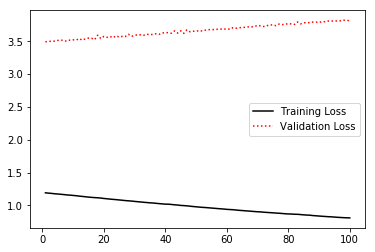

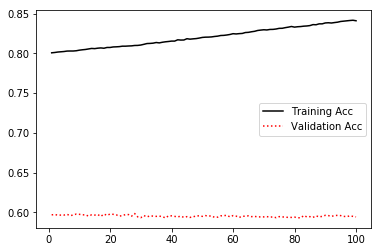

In [48]:
import matplotlib.pyplot as plt

epoch = range(1, epochs + 1)

plt.plot(epoch, history.history['loss'], '-k', label = 'Training Loss')
plt.plot(epoch, history.history['val_loss'], ':r', label = 'Validation Loss')
plt.legend()
plt.show()

plt.plot(epoch, history.history['acc'], '-k', label = 'Training Acc')
plt.plot(epoch, history.history['val_acc'], ':r', label = 'Validation Acc')
plt.legend()
plt.show()

In [50]:
encoder_model = Model(encoder_inputs, encoder_states)
save_model(encoder_model, 'models/pretrained-eng-to-kor-encoder.hdf5')

decoder_state_input_h = Input(shape = (units,))
decoder_state_input_c = Input(shape = (units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedded_p = decoder_embedding_layer(decoder_inputs)
decoder_outputs_p, state_h_p, state_c_p = decoder_rnn(
    decoder_embedded_p, initial_state = decoder_states_inputs)

decoder_states_p = [state_h_p, state_c_p]
decoder_outputs_p = decoder_softmax_layer(decoder_outputs_p)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, 
                      [decoder_outputs_p] + decoder_states_p)

In [54]:
index_to_source = dict((i, char) for char, i in source_t.word_index.items())
index_to_target = dict((i, char) for char, i in target_t.word_index.items())

In [75]:
def decode_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_t.word_index['sos']
    
    stop_condition = False
    decoded_sentence = ''
    
    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition: 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_target[sampled_token_index]
        decoded_sentence += ' ' + sampled_char
        
        # 문장 끝에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == 'eos' or
           len(decoded_sentence) > target_max_length):
            stop_condition = True
        
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # 상태를 업데이트
        states_value = [h, c]
        
    return decoded_sentence